In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries & Data

In [5]:
import pandas as pd;
train = pd.read_csv('../input/hackerearth-price-pred/train.csv');
test = pd.read_csv('../input/hackerearth-price-pred/test.csv');
ss = pd.read_csv('../input/hackerearth-price-pred/sample_submission.csv')

In [6]:
import numpy as np
import matplotlib.pyplot as plt;
import seaborn as sns;
from sklearn.impute import SimpleImputer;
from sklearn.compose import ColumnTransformer;
from sklearn.pipeline import Pipeline;
from sklearn.preprocessing import LabelEncoder;
from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LinearRegression ;
from sklearn.linear_model import LogisticRegression;
from sklearn.linear_model import Ridge, Lasso;
from sklearn.metrics import mean_squared_error;
from sklearn.metrics import r2_score;
from sklearn.preprocessing import PolynomialFeatures;
from sklearn.svm import SVR;
from sklearn.svm import SVC;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.tree import DecisionTreeRegressor;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.ensemble import RandomForestRegressor;
from sklearn.neighbors import KNeighborsClassifier;
from sklearn.neighbors import KNeighborsRegressor;
from sklearn.naive_bayes import GaussianNB;
import xgboost as xgb;
from xgboost import XGBClassifier;
from xgboost import XGBRegressor;

# Missing Values

In [7]:
train['Stall_no'] = train['Stall_no'].fillna(train['Stall_no'].mean())
train['Discount_avail'] = train['Discount_avail'].fillna(train['Discount_avail'].mean())
train['charges_1'] = train['charges_1'].fillna(train['charges_1'].mean())
train['charges_2 (%)'] = train['charges_2 (%)'].fillna(train['charges_2 (%)'].mean())
train['Minimum_price'] = train['Minimum_price'].fillna(train['Minimum_price'].mean())
train['Maximum_price'] = train['Maximum_price'].fillna(train['Maximum_price'].mean())
train['Selling_Price'] = train['Selling_Price'].fillna(train['Selling_Price'].mean())

In [8]:
test['Stall_no'] = test['Stall_no'].fillna(test['Stall_no'].mean())
test['Discount_avail'] = test['Discount_avail'].fillna(test['Discount_avail'].mean())
test['charges_1'] = test['charges_1'].fillna(test['charges_1'].mean())
test['charges_2 (%)'] = test['charges_2 (%)'].fillna(test['charges_2 (%)'].mean())
test['Minimum_price'] = test['Minimum_price'].fillna(test['Minimum_price'].mean())
test['Maximum_price'] = test['Maximum_price'].fillna(test['Maximum_price'].mean())

# Handling Catagorical Data

In [9]:
train = train.drop(columns = 'Customer_name', axis = 1);
test = test.drop(columns = 'Customer_name', axis = 1)

In [10]:
train['Loyalty_customer'].unique();
l = {'Yes': 1, 'No': 2};
train['Loyalty_customer'] = train['Loyalty_customer'].map(l);
test['Loyalty_customer'] = test['Loyalty_customer'].map(l)

In [11]:
train['Product_Category'].unique();
p = {'Fashion': 1, 'Child_care': 2, 'Educational': 3, 'Repair': 4, 'Technology': 5,
       'Cosmetics': 6, 'Hospitality': 7, 'Organic': 8, 'Pet_care': 9, 'Home_decor': 10};
train['Product_Category'] = train['Product_Category'].map(p);
test['Product_Category'] = test['Product_Category'].map(p)

# Handling Date & Time Data

In [12]:
train['datetime'] = pd.to_datetime(train['instock_date'])
train['minutes'] = train['datetime'].dt.hour * 60 + train['datetime'].dt.minute + train['datetime'].dt.second/60
train['year']= train['datetime'].dt.year
train['month']= train['datetime'].dt.month
train['day']= train['datetime'].dt.day

In [13]:
test['datetime'] = pd.to_datetime(test['instock_date'])
test['minutes'] = test['datetime'].dt.hour * 60 + test['datetime'].dt.minute + test['datetime'].dt.second/60
test['year']= test['datetime'].dt.year
test['month']= test['datetime'].dt.month
test['day']= test['datetime'].dt.day

# Label Encoding

In [14]:
le = LabelEncoder()

In [15]:
train['month'] = le.fit_transform(train['month']);
train['day'] = le.fit_transform(train['day']);
train['minutes'] = le.fit_transform(train['minutes']);
train['year'] = le.fit_transform(train['year'])

In [16]:
test['month'] = le.fit_transform(test['month']);
test['day'] = le.fit_transform(test['day']);
test['minutes'] = le.fit_transform(test['minutes']);
test['year'] = le.fit_transform(test['year'])

In [17]:
train = train.drop(columns = 'datetime', axis = 1);
test = test.drop(columns = 'datetime', axis = 1)

In [18]:
train = train.drop(columns = ['Product_id', 'instock_date'], axis = 1);
test = test.drop(columns = ['Product_id', 'instock_date'], axis = 1)

# Visuzalization

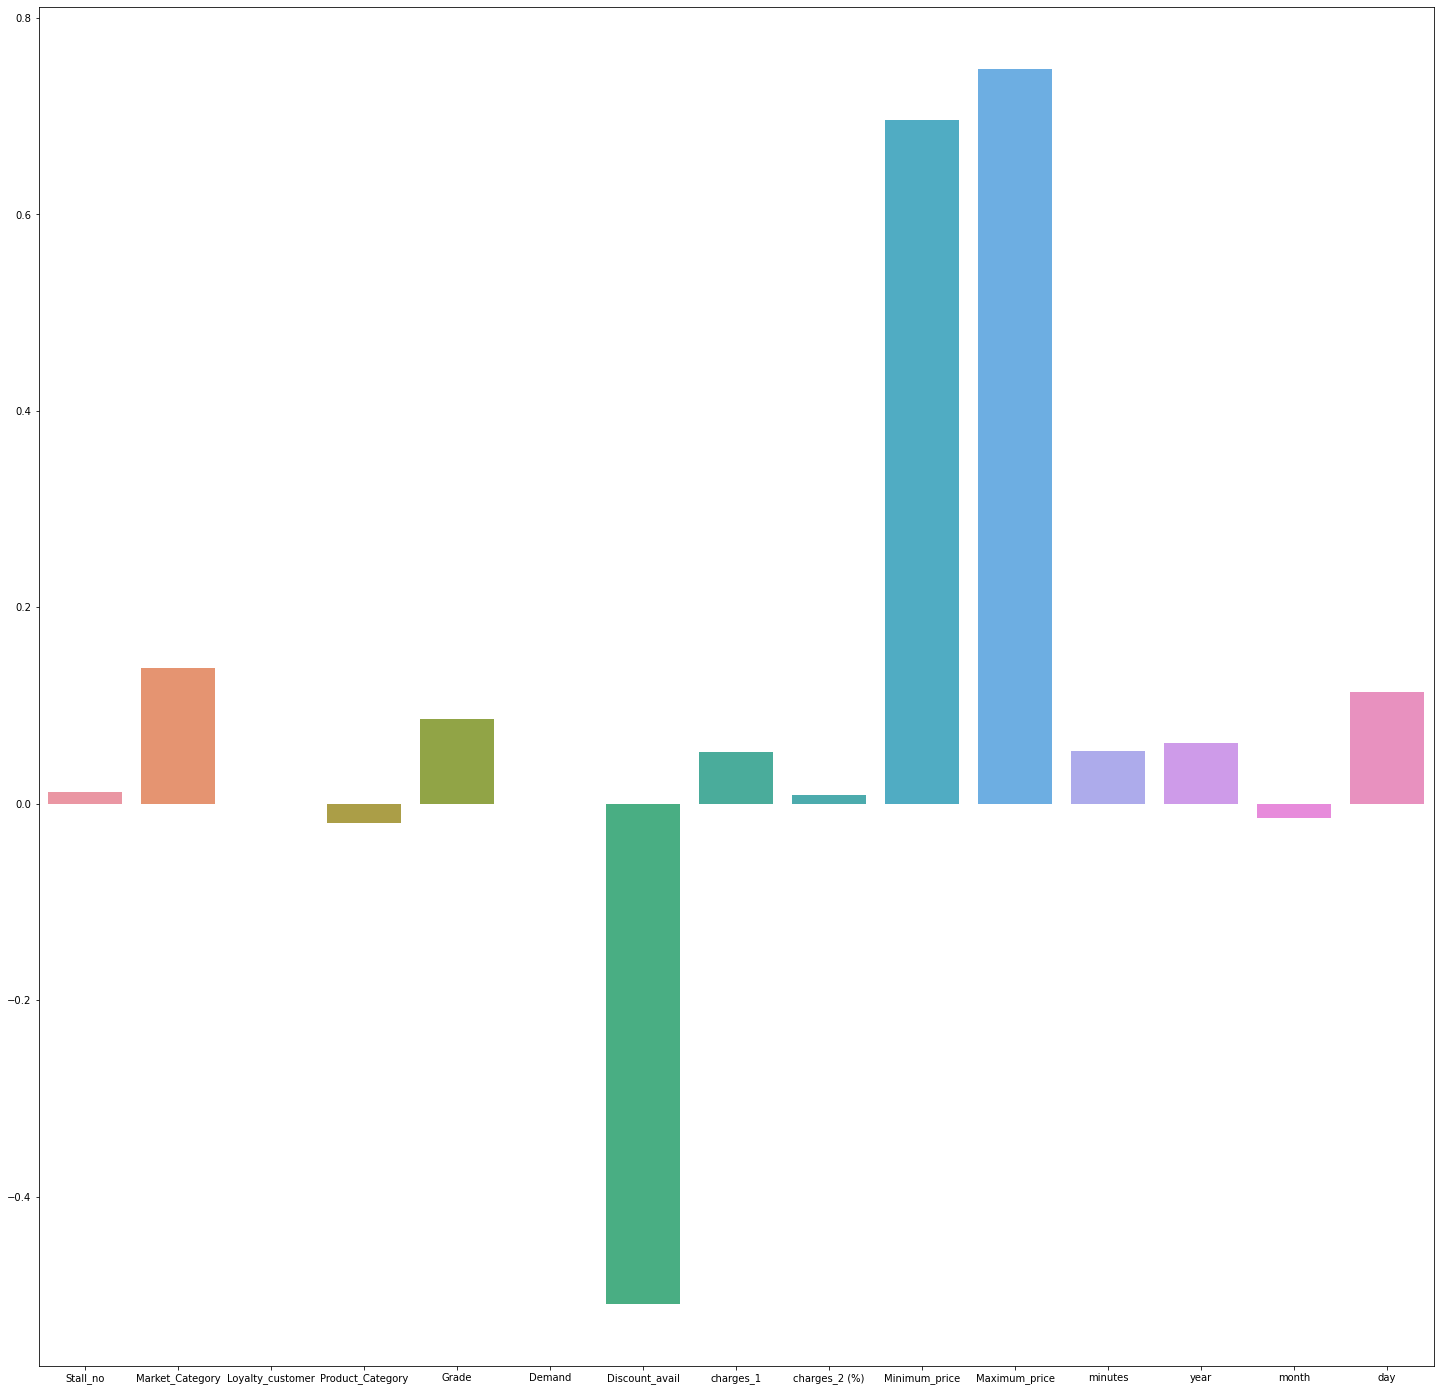

In [19]:
plt.figure(figsize = (25,25))
fineTech_appData3 = train.drop(['Selling_Price'], axis = 1) 
sns.barplot(fineTech_appData3.columns,fineTech_appData3.corrwith(train['Selling_Price'])) 

# Test Train Split

In [20]:
x = train[['Discount_avail', 'Minimum_price', 'Maximum_price']];
y = train[['Selling_Price']]

In [21]:
test1 = test[['Discount_avail', 'Minimum_price', 'Maximum_price']]

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 55)

# XGBoost

In [28]:
xx = XGBRegressor(max_depth= 5, 
    subsample = 0.9,
    colsample_bylevel=1,
    colsample_bytree=1,
    min_child_weight= 12,
    reg_lambda= 0.95);
xx.fit(xtrain, ytrain);
xx.score(xtest, ytest)

0.9368413492982101

In [29]:
modelx = xx.predict(test1);
modelDatax = pd.DataFrame(modelx, columns = ['Selling_Price']);
modelDatax['Selling_Price'] = modelDatax['Selling_Price'].abs()

In [30]:
modelDatax.set_index('Selling_Price').to_csv('submission3.csv')

# Random Forest

In [31]:
rf = RandomForestRegressor();
rf.fit(xtrain, ytrain);
modelr = rf.predict(test1);
modelDatar = pd.DataFrame(modelr, columns = ['Selling_Price']);
modelDatar['Selling_Price'] = modelDatar['Selling_Price'].abs()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [32]:
modelDatar.set_index('Selling_Price').to_csv('submission4.csv')

# Lightgbm

In [33]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()
lgb.fit(xtrain,ytrain);
modell = lgb.predict(test1);
modelDatal = pd.DataFrame(modell, columns = ['Selling_Price']);
modelDatal['Selling_Price'] = modelDatal['Selling_Price'].abs()

In [34]:
modelDatal.set_index('Selling_Price').to_csv('submission5.csv')

# Linear Regression

In [23]:
lin = LinearRegression();
lin.fit(xtrain, ytrain);
modellin = lin.predict(test1);
modelDatalin = pd.DataFrame(modellin, columns = ['Selling_Price']);
modelDatalin['Selling_Price'] = modelDatalin['Selling_Price'].abs()

In [24]:
modelDatalin.set_index('Selling_Price').to_csv('submission8.csv')

# Decision Tree

In [25]:
dc = DecisionTreeRegressor();
dc.fit(xtrain, ytrain);
modeldc = dc.predict(test1);
modelDatadc = pd.DataFrame(modeldc, columns = ['Selling_Price']);
modelDatadc['Selling_Price'] = modelDatadc['Selling_Price'].abs()

In [26]:
modelDatadc.set_index('Selling_Price').to_csv('submission9.csv')

# Lasso Regression

In [27]:
La = Lasso();
La.fit(xtrain, ytrain);
modelLa = La.predict(test1);
modelDataLa = pd.DataFrame(modelLa, columns = ['Selling_Price']);
modelDataLa['Selling_Price'] = modelDataLa['Selling_Price'].abs()

In [28]:
modelDataLa.set_index('Selling_Price').to_csv('submission10.csv')